In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

COL_USER   = "name"
COL_START  = "start_time"
COL_USAGE  = "usage_time"
COL_IP     = "IP"
COL_MAC    = "MAC"
COL_UPLOAD = "upload"
COL_DOWN   = "download"
COL_TOTAL  = "total_transfer"
COL_REASON = "seession_break_reason"


In [21]:
df = pd.read_csv("InternetUsage.csv") 

# Observing general traits of the dataframe.
print(df.shape)
print(df.columns)
df.head()


(4712, 9)
Index(['name', 'start_time', 'usage_time', 'IP', 'MAC', 'upload', 'download',
       'total_transfer', 'seession_break_reason'],
      dtype='object')


,name,start_time,usage_time,IP,MAC,upload,download,total_transfer,seession_break_reason
0,user1,2022-05-10 02:59:32,00:00:36:28,10.55.14.222,48:E7:DA:58:22:E9,15861.76,333168.64,349030.40,Idle-Timeout
1,user1,2022-05-10 18:53:27,00:01:49:56,10.55.2.253,48:E7:DA:58:22:E9,16957.44,212152.32,229109.76,Idle-Timeout
2,user1,2022-05-10 21:20:44,00:01:35:00,10.55.2.253,48:E7:DA:58:22:E9,14080.0,195153.92,209233.92,Idle-Timeout
3,user1,2022-05-11 00:37:42,00:00:26:00,10.55.2.253,48:E7:DA:58:22:E9,5242.88,40806.4,46049.28,Idle-Timeout
4,user1,2022-05-11 02:59:38,00:00:11:52,10.55.2.253,48:E7:DA:58:22:E9,22067.2,10772.48,32839.68,Idle-Timeout


In [22]:
df.isnull().sum()

# Checking to see if any columns are invalid or empty.

name                     0
start_time               0
usage_time               0
IP                       0
MAC                      0
upload                   0
download                 0
total_transfer           0
seession_break_reason    9
dtype: int64

In [23]:
# The dataset has been loaded. Each row represents one record entry.
# There are 4712 entries and 9 columns, and some null values in session_break_reason.

df[COL_REASON] = df[COL_REASON].fillna("Unknown")
df[COL_START] = pd.to_datetime(df[COL_START], errors="coerce")

# This is to change the usage time to seconds.

def parse_timetosec(t):
    if pd.isna(t):
        return np.nan
    parts = str(t).split(":")
    if len(parts) != 4:
        return np.nan
    h, m, s, ms = map(int, parts)
    return h*3600 + m*60 + s + ms/100  

df["usage_seconds"] = df[COL_USAGE].apply(parse_timetosec)

df = df.dropna(subset=[COL_START, "usage_seconds"])
df = df[df["usage_seconds"] > 0]


In [24]:
# Error handling for upload, download, total times.
for c in [COL_UPLOAD, COL_DOWN, COL_TOTAL]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[COL_TOTAL, COL_UPLOAD, COL_DOWN])
df = df[(df[COL_TOTAL] >= 0) & (df[COL_UPLOAD] >= 0) & (df[COL_DOWN] >= 0)]


In [25]:
# What we are going to predict.
df["transfer_rate"] = df[COL_TOTAL] / df["usage_seconds"]

In [26]:
# Exploring the dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4710 entries, 0 to 4711
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   4710 non-null   object        
 1   start_time             4710 non-null   datetime64[ns]
 2   usage_time             4710 non-null   object        
 3   IP                     4710 non-null   object        
 4   MAC                    4710 non-null   object        
 5   upload                 4710 non-null   float64       
 6   download               4710 non-null   float64       
 7   total_transfer         4710 non-null   float64       
 8   seession_break_reason  4710 non-null   object        
 9   usage_seconds          4710 non-null   float64       
 10  transfer_rate          4710 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 441.6+ KB


In [40]:
dt = df[COL_START]

# Feature Engineering

df["hour"] = dt.dt.hour
df["dayofweek"] = dt.dt.dayofweek
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)


df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)


df["bytes_per_sec"] = df[COL_TOTAL] / df["usage_seconds"]
df["log_total_transfer"] = np.log1p(df[COL_TOTAL])
df["log_usage_seconds"] = np.log1p(df["usage_seconds"])


df["upload_ratio"] = df[COL_UPLOAD] / (df[COL_TOTAL] + 1e-9)
df["download_ratio"] = df[COL_DOWN] / (df[COL_TOTAL] + 1e-9)


df["idle_timeout"] = (df[COL_REASON].astype(str) == "Idle-Timeout").astype(int) # Considered only this as Idle_Timeout was seen to dominate.


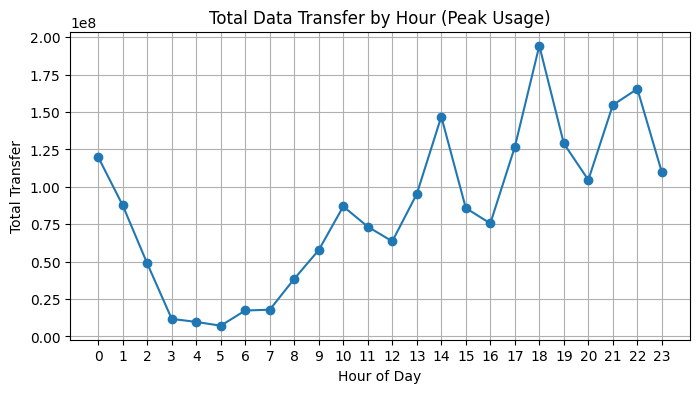

In [ ]:
# Peak Usage Hours.

hourly_transfer = (
    df.groupby("hour")[COL_TOTAL]
      .sum()
      .sort_index()
)

plt.figure(figsize=(8,4))
plt.plot(hourly_transfer.index, hourly_transfer.values, marker="o")
plt.title("Total Data Transfer by Hour (Peak Usage)")
plt.xlabel("Hour of Day")
plt.ylabel("Total Transfer")
plt.xticks(range(0,24))
plt.grid(True)
plt.show()


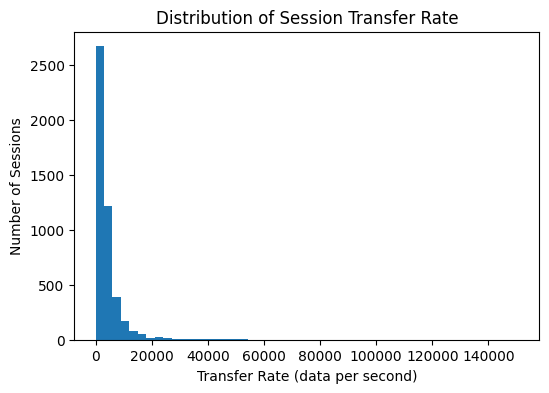

In [ ]:
# Session Intensity Distribution.

plt.figure(figsize=(6,4))
plt.hist(df["transfer_rate"], bins=50)
plt.title("Distribution of Session Transfer Rate")
plt.xlabel("Transfer Rate (data per second)")
plt.ylabel("Number of Sessions")
plt.show()

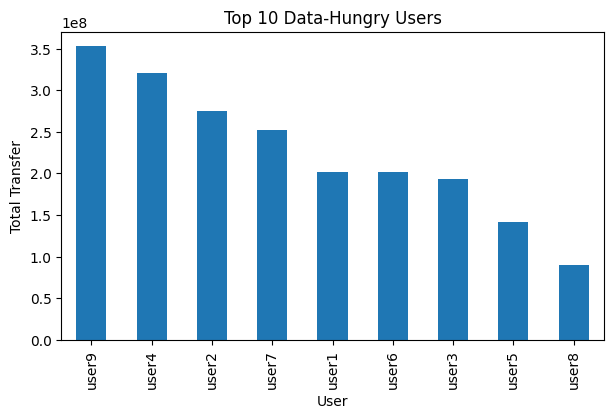

In [ ]:
# Data Hungry Users.

user_total = (
    df.groupby(COL_USER)[COL_TOTAL]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(7,4))
user_total.plot(kind="bar")
plt.title("Top 10 Data-Hungry Users")
plt.xlabel("User")
plt.ylabel("Total Transfer")
plt.show()

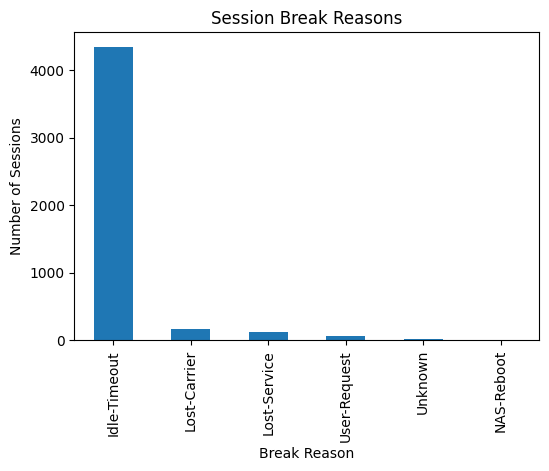

In [45]:
# Session Break Reasons.

reason_counts = df[COL_REASON].value_counts()

plt.figure(figsize=(6,4))
reason_counts.plot(kind="bar")
plt.title("Session Break Reasons")
plt.xlabel("Break Reason")
plt.ylabel("Number of Sessions")
plt.show()


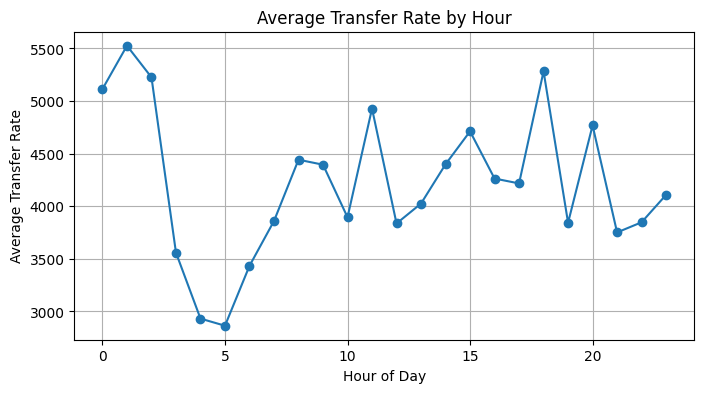

In [68]:
# Transfer Rate Vs Hour.

hourly_rate = (
    df.groupby("hour")["transfer_rate"]
      .mean()
      .sort_index()
)

plt.figure(figsize=(8,4))
plt.plot(hourly_rate.index, hourly_rate.values, marker="o")
plt.title("Average Transfer Rate by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Transfer Rate")
plt.grid(True)
plt.show()

In [72]:
feature_cols = [
    "hour", "dayofweek", "is_weekend",
    "hour_sin", "hour_cos", "log_total_transfer", "log_usage_seconds",
    "upload_ratio", "download_ratio",
    "idle_timeout"
]

X = df[feature_cols].replace([np.inf, -np.inf], np.nan).dropna()
y = df.loc[X.index, "transfer_rate"]

# Sort by time (important!)
df_sorted = df.loc[X.index].sort_values(COL_START)
X = df_sorted[feature_cols]
y = df_sorted["transfer_rate"]

# Time-based split: last 20% test
split = int(0.8 * len(df_sorted))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

model = RandomForestRegressor(
    n_estimators=300,
    random_state=4,
    n_jobs=-1,
    min_samples_leaf=3
)
model.fit(X_train, y_train)

pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("R²:", r2_score(y_test, pred))


MAE: 516.5927266402899
R²: 0.7456307274839178


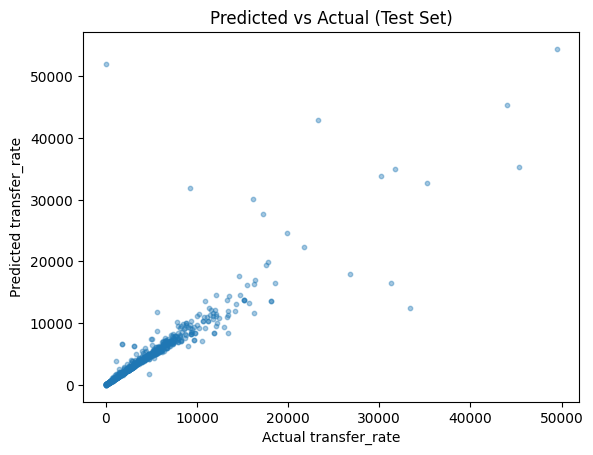

In [73]:
# (A) Predicted vs Actual scatter
plt.figure()
plt.scatter(y_test, pred, s=10, alpha=0.4)
plt.xlabel("Actual transfer_rate")
plt.ylabel("Predicted transfer_rate")
plt.title("Predicted vs Actual (Test Set)")
plt.show()

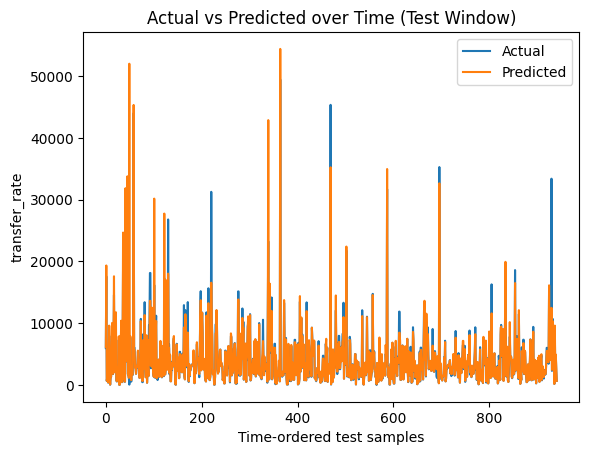

In [74]:
# (B) Actual vs Predicted over time (test window)
plt.figure()
plt.plot(y_test.values, label="Actual")
plt.plot(pred, label="Predicted")
plt.title("Actual vs Predicted over Time (Test Window)")
plt.xlabel("Time-ordered test samples")
plt.ylabel("transfer_rate")
plt.legend()
plt.show()

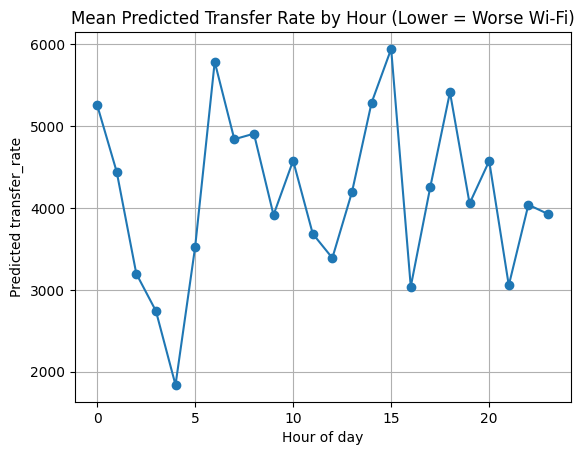

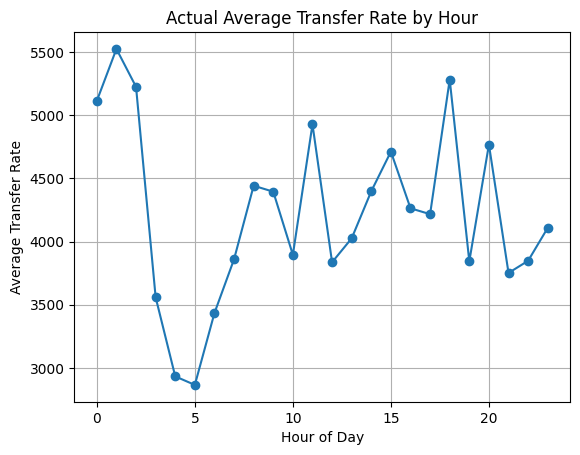


Worst 5 hours (predicted):
 hour
4     1838.737506
3     2742.218525
16    3038.605087
21    3055.145872
2     3197.510238
dtype: float64

Best 5 hours (predicted):
 hour
15    5942.418282
6     5784.571591
18    5412.893842
14    5284.117585
0     5259.847288
dtype: float64


In [ ]:
# (C) Worst hours based on mean predicted performance
test_hours = df_sorted.iloc[split:]["hour"].reset_index(drop=True)
pred_series = pd.Series(pred)
hour_pred_mean = pred_series.groupby(test_hours).mean().sort_index()

plt.figure()
plt.plot(hour_pred_mean.index, hour_pred_mean.values,marker='o')
plt.title("Mean Predicted Transfer Rate by Hour (Lower = Worse Wi-Fi)")
plt.xlabel("Hour of day")
plt.ylabel("Predicted transfer_rate")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(hourly_rate.index, hourly_rate.values, marker="o")
plt.title("Actual Average Transfer Rate by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Transfer Rate")
plt.grid(True)
plt.show()

worst_hours = hour_pred_mean.sort_values().head(5)
best_hours = hour_pred_mean.sort_values(ascending=False).head(5)

print("\nWorst 5 hours (predicted):\n", worst_hours)
print("\nBest 5 hours (predicted):\n", best_hours)

worst_actual_hours = actual_hourly_rate.sort_values().head(5)
best_actual_hours = actual_hourly_rate.sort_values(ascending=False).head(5)

print("Worst 5 ACTUAL hours (slowest Wi-Fi):")
print(worst_actual_hours)

print("\nBest 5 ACTUAL hours (fastest Wi-Fi):")
print(best_actual_hours)


log_total_transfer    0.289026
upload_ratio          0.255283
log_usage_seconds     0.242022
download_ratio        0.170669
dayofweek             0.014445
hour                  0.010897
hour_cos              0.009083
hour_sin              0.006929
idle_timeout          0.001320
is_weekend            0.000328
dtype: float64


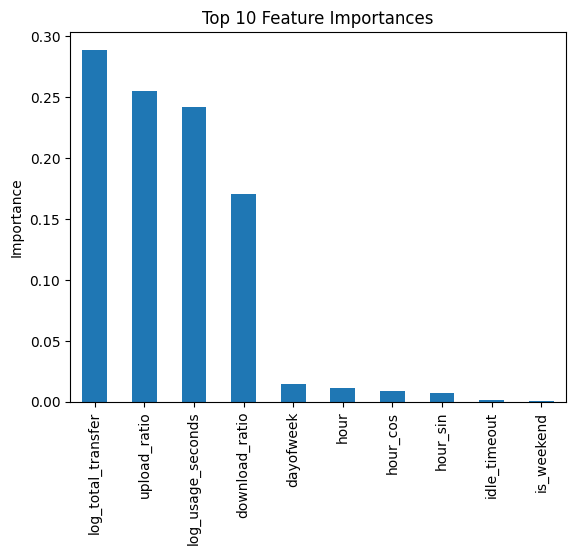

In [ ]:
# Finding importance weights of individual features.

importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(importances)

plt.figure()
importances.head(10).plot(kind="bar")
plt.title("Top 10 Feature Importances")
plt.ylabel("Importance")
plt.show()
